In [1]:
%load_ext autoreload
%autoreload 2

import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform, color
from colorize import network, util

In [2]:
net = network.Net()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
            Conv2d-2         [-1, 64, 112, 112]          36,928
       BatchNorm2d-3         [-1, 64, 112, 112]             128
            Conv2d-4        [-1, 128, 112, 112]          73,856
            Conv2d-5          [-1, 128, 56, 56]         147,584
       BatchNorm2d-6          [-1, 128, 56, 56]             256
            Conv2d-7          [-1, 256, 56, 56]         295,168
            Conv2d-8          [-1, 256, 56, 56]         590,080
            Conv2d-9          [-1, 256, 28, 28]         590,080
      BatchNorm2d-10          [-1, 256, 28, 28]             512
           Conv2d-11          [-1, 512, 28, 28]       1,180,160
           Conv2d-12          [-1, 512, 28, 28]       2,359,808
           Conv2d-13          [-1, 512, 28, 28]       2,359,808
      BatchNorm2d-14          [-1, 512,

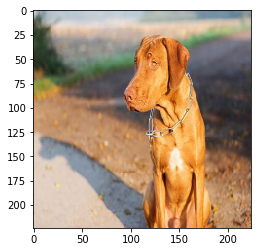

Decoded: (224, 224, 3)
RGB: (224, 224, 3)


/home/oskar/Programs/miniconda3/envs/ann/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


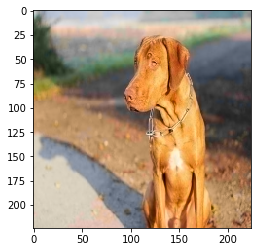

In [3]:
images = glob.glob("data/**/*.jpg")
for image in images:
    img = io.imread(image)
    img = transform.resize(img, (224, 224))
    plt.imshow(img)
    plt.show()
    
    lab = color.rgb2lab(img)
    X = lab[:,:,0][...,np.newaxis]
    Y = transform.resize(lab[:,:,1:], (56, 56))
    Z = util.soft_encode(Y)
    Y_decoded = util.decode(Z)
    
    Y_decoded = transform.resize(Y_decoded, (224, 224))
    lab_decoded = np.concatenate((X, Y_decoded), axis=2)
    print('Decoded:', lab_decoded.shape)
    rgb = color.lab2rgb(lab_decoded)
    print('RGB:', rgb.shape)
    plt.imshow(rgb)
    """
    X = (lab[:,:,0][np.newaxis,np.newaxis,...] - 50) / 50
    print('X:', X.shape, X.min(), X.max())
    
    Y = transform.resize(lab[:,:,1:], (56, 56))
    Z = util.soft_encode(Y)
    Z = Z.transpose(2, 0, 1)[np.newaxis,...]
    Z = torch.tensor(Z, dtype=torch.float32)
    print('Z:', Z.shape)
    
    Z_hat = net.forward(X)
    print('Z_hat:', Z_hat.shape)
    """
    break

In [4]:
# Normalize X?
X_tensor = torch.tensor(X.transpose(2, 0, 1)[np.newaxis,...], dtype=torch.float32)
Z_tensor = torch.tensor(Z.transpose(2, 0, 1)[np.newaxis,...], dtype=torch.float32)
print(X_tensor.shape)
print(Z_tensor.shape)

import torch.optim as optim
optimizer = torch.optim.Adam(net.parameters())

for epoch in range(50):
    running_loss = 0.0

    optimizer.zero_grad()

    Z_hat = net(X_tensor)
    loss = util.multinomial_cross_entropy_loss(Z_hat, Z_tensor)
    loss.backward()
    optimizer.step()

    print(f'Loss epoch {epoch}:', loss.item())
print('Finished Training')

torch.Size([1, 1, 224, 224])
torch.Size([1, 313, 56, 56])
Loss epoch 0: 0.01835223287343979
Loss epoch 1: 0.018069906160235405
Loss epoch 2: 0.01711764559149742
Loss epoch 3: 0.01577823981642723
Loss epoch 4: 0.014267832040786743
Loss epoch 5: 0.013380086049437523
Loss epoch 6: 0.012524009682238102
Loss epoch 7: 0.011926604434847832
Loss epoch 8: 0.011309691704809666
Loss epoch 9: 0.010990940034389496
Loss epoch 10: 0.010622925125062466
Loss epoch 11: 0.010377633385360241
Loss epoch 12: 0.010095663368701935
Loss epoch 13: 0.009872250258922577
Loss epoch 14: 0.009619414806365967
Loss epoch 15: 0.009406473487615585
Loss epoch 16: 0.00921056792140007
Loss epoch 17: 0.009024882689118385
Loss epoch 18: 0.008861251175403595
Loss epoch 19: 0.008693892508745193
Loss epoch 20: 0.008520619012415409
Loss epoch 21: 0.008352784439921379
Loss epoch 22: 0.008175203576683998
Loss epoch 23: 0.008013807237148285
Loss epoch 24: 0.00788790825754404
Loss epoch 25: 0.007796980440616608
Loss epoch 26: 0.0077

Decoded: (224, 224, 3)
RGB: (224, 224, 3)


/home/oskar/Programs/miniconda3/envs/ann/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 47 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


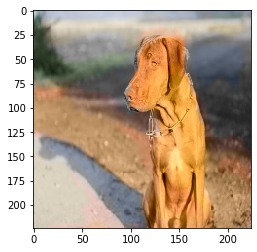

In [5]:
# Show image
Y_decoded = util.decode(Z_hat.data.numpy())
Y_decoded = np.squeeze(Y_decoded.transpose(2, 3, 1, 0), axis=3)
Y_decoded = transform.resize(Y_decoded, (224, 224))
lab_decoded = np.concatenate((X, Y_decoded), axis=2)
print('Decoded:', lab_decoded.shape)
rgb = color.lab2rgb(lab_decoded)
print('RGB:', rgb.shape)
plt.imshow(rgb)